In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
from scipy.interpolate import interp1d
from scipy.linalg import hankel

import math

In [2]:
### ====  1. Load the raw data ============

datadir = 'data_RGCs/'
stim = np.squeeze(loadmat(f'{datadir}Stim.mat')['Stim']) # contains stimulus value at each frame
stim_times = np.squeeze(loadmat(f'{datadir}stimtimes.mat')['stimtimes']) # contains time in seconds at each frame (120 Hz)
all_spike_times = [np.squeeze(x) for x in np.squeeze(loadmat(f'{datadir}SpTimes.mat')['SpTimes'])] # time of spikes for 4 neurons (in units of stim frames)
num_cells = len(all_spike_times)

print(f'length of stimulus: {stim.shape}')
print(f'Number of spikes for each of 4 neurons: {" ".join([str(x.size) for x in all_spike_times])}')

# Compute some basic statistics on the stimulus
dt_stim = stim_times[1] - stim_times[0] # time bin size

# Pick a cell to work with
cell_idx = 2
spike_times = all_spike_times[cell_idx]

length of stimulus: (144051,)
Number of spikes for each of 4 neurons: 31528 21553 49954 43126


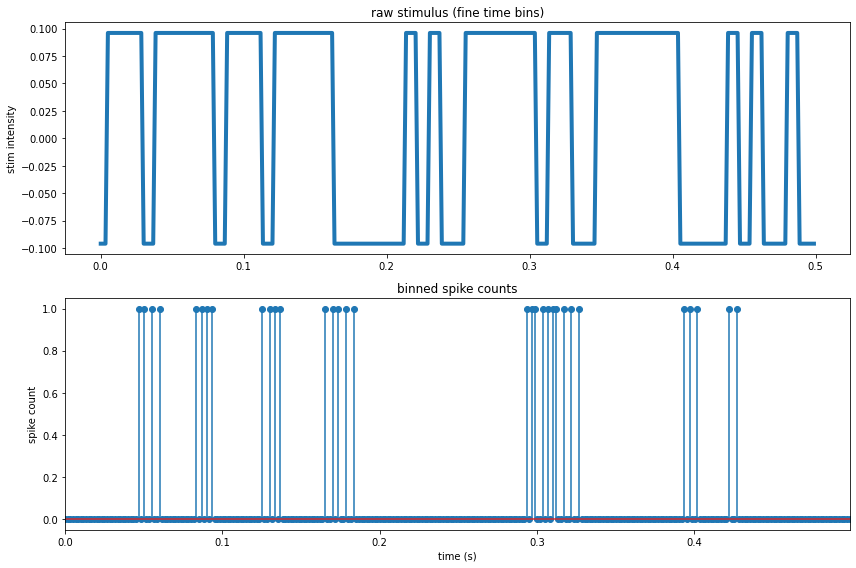

In [3]:
### == 2. Upsample to get finer timescale representation of stim and spikes === 

# The need to regularize GLM parameter estimates is acute when we don't
# have enough data relative to the number of parameters we're trying to
# estimate, or when using correlated (eg naturalistic) stimuli, since the
# stimuli don't have enough power at all frequencies to estimate all
# frequency components of the filter. To simulate that setting we will
# consider the binary white-noise stimulus sampled on a finer time lattice
# than the original stimulus (resulting in 1.6 ms time bins instead of 8ms
# bins defined by the stimulus refresh rate).
#
# For speed of our code and to illustrate the advantages of regularization,
# let's use only a reduced (5-minute) portion of the dataset:
num_time_bins = 120*60*1  # of time bins for 1 minute of data 
stim = stim[:num_time_bins] # reduce stimulus to selected time bins
spike_times = spike_times[np.where(spike_times<num_time_bins*dt_stim)] # reduce spikes

# Now upsample to finer temporal grid
upsamp_factor = 5 # divide each time bin by this factor
dt_fine = dt_stim/upsamp_factor # use bins 100 time bins finer
tt_fine = np.linspace(dt_fine/2, num_time_bins*dt_stim, int((num_time_bins*dt_stim)/dt_fine)+1, endpoint=False).T # fine time grid for upsampled stim
inter_func = interp1d(np.arange(num_time_bins)*dt_stim, stim, kind='nearest', bounds_error=False, fill_value='extrapolate')
stim_fine = inter_func(tt_fine)/upsamp_factor
num_fine_bins = num_time_bins*upsamp_factor  # length of upsampled stimulus

# Visualize the upsampled data.
fig = plt.figure(figsize=[12,8])
plt.subplot(211)
iiplot = np.arange(60*upsamp_factor) # bins of stimulus to plot
ttplot = iiplot*dt_fine # time bins of stimulus
plt.plot(ttplot,stim_fine[iiplot], linewidth=4)
plt.title('raw stimulus (fine time bins)')
plt.ylabel('stim intensity')
# Should notice stimulus now constant for many bins in a row

# Bin the spike train and replot binned counts
binned_spike_times = np.histogram(spike_times,tt_fine)[0].T
plt.subplot(212)
plt.stem(ttplot,binned_spike_times[iiplot])
plt.title('binned spike counts')
plt.ylabel('spike count')
plt.xlabel('time (s)')
plt.xlim(ttplot[0], ttplot[-1]) # Now maximum 1 spike per bin!
plt.tight_layout()
plt.show()

In [4]:
### ===== 3. Divide data into "training" and "test" sets for cross-validation ====

train_frac = .8  # fraction of data to use for training
num_train = math.ceil(num_fine_bins*train_frac)  # number of training samples
num_test = num_fine_bins-num_train # number of test samples
iitest = np.arange(num_test) # time indices for test
iitrain = np.arange(num_test,num_fine_bins)   # time indices for training
stim_train = stim_fine[iitrain] # training stimulus
stim_test = stim_fine[iitest] # test stimulus
binned_spikes_train = binned_spike_times[iitrain]
binned_spikes_test =  binned_spike_times[iitest]

print('Dividing data into training and test sets:')
print(f'Training: {num_train} samples ({np.sum(binned_spikes_train)} spikes)')
print(f'    Test: {num_test} samples ({np.sum(binned_spikes_test)} spikes)\n')

# Set the number of time bins of stimulus to use for predicting spikes
ntfilt = 20*upsamp_factor  

# build the design matrix, training data
padded_stim_train = np.hstack((np.zeros(ntfilt-1), stim_train))
design_mat_train = np.hstack((np.ones((num_train,1)), # constant column of ones
    hankel(padded_stim_train[:-ntfilt+1], stim_train[-ntfilt:]))) # stimulus

# Build design matrix for test data
padded_stim_test = np.hstack((np.zeros(ntfilt-1), stim_test))
design_mat_test = np.hstack((np.ones((num_test,1)), # constant column of ones
    hankel(padded_stim_test[:-ntfilt+1], stim_test[-ntfilt:]))) # stimulus

Dividing data into training and test sets:
Training: 28800 samples (2109 spikes)
    Test: 7200 samples (557 spikes)



In [5]:
### ===== 3.99 Create log-likelihood functions ===========
# Let's define some functions that calculates log-likelihood, gradient, and the hessian
# so we can pass them to scipy's automatic solver that will give us
# the optimized parameter fit using ML.

def neglogli_poissGLM(thetas, xx, yy, dt_bin, vals_to_return=3):
    """ Compute negative log-likelihood of data under Poisson GLM model with
        exponential nonlinearity.
        
        Args
        ----
        thetas: ndarray (d X 1)
            parameter vector
        xx: ndarray (T X d)
            design matrix
        yy: ndarray (T X 1)
            response variable (spike count per time bin)
        dt_bin: float
            time bin size used
        vals_to_return: int
            which of negative log-likelihood (0), gradient (1), or hessian (2) to return.
            3 returns all three values. This is necessary due to scipy.optimize.minimize
            requiring the three separate functions with a single return value for each.
            
        Returns
        -------
        neglogli: float
            negative log likelihood of spike train
        dL: ndarray (d X 1)
            gradient
        H: ndarray (d X d)
            Hessian (second derivative matrix)
    """
    
    # Compute GLM filter output and conditional intensity
    vv = xx @ thetas # filter output
    rr = np.exp(vv) * dt_bin # conditional intensity (per bin)

    # ---------  Compute log-likelihood -----------
    Trm1 = -vv.T @ yy; # spike term from Poisson log-likelihood
    Trm0 = np.sum(rr)  # non-spike term 
    neglogli = Trm1 + Trm0
    
    # ---------  Compute Gradient -----------------
    dL1 = -xx.T @ yy # spiking term (the spike-triggered average)
    dL0 = xx.T @ rr # non-spiking term
    dL = dL1 + dL0
    
    # ---------  Compute Hessian -------------------
    H = xx.T @ (xx * np.transpose([rr])) # non-spiking term
    
    if vals_to_return == 3:
        return neglogli, dL, H
    else:
        return [neglogli, dL, H][vals_to_return]

C:\Users\jcian\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


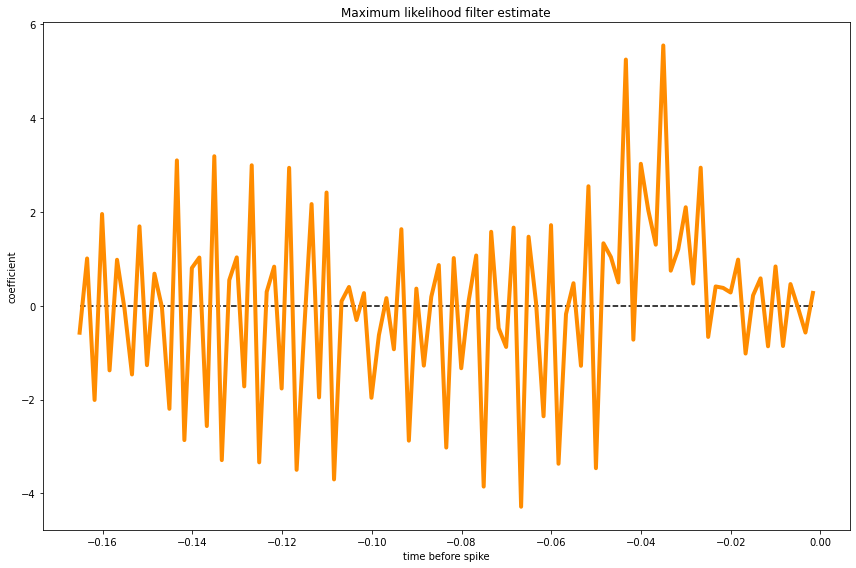

In [7]:
### === 4. Fit poisson GLM using ML ====================

from scipy.optimize import minimize
# Compute maximum likelihood estimate (using 'fminunc' instead of 'glmfit')
sta = (design_mat_train.T @ binned_spikes_train)/np.sum(binned_spikes_train) # compute STA for initialization

# -- Make loss functions and minimize -----
loss_func = lambda prs : neglogli_poissGLM(prs, design_mat_train, binned_spikes_train, dt_fine, vals_to_return=0)
grad_func = lambda prs : neglogli_poissGLM(prs, design_mat_train, binned_spikes_train, dt_fine, vals_to_return=1)
hess_func = lambda prs : neglogli_poissGLM(prs, design_mat_train, binned_spikes_train, dt_fine, vals_to_return=2)
optimizer = minimize(fun=loss_func, x0=sta, method='trust-ncg', jac=grad_func, hess=hess_func, options={'disp':True, 'gtol':1e-6})
filt_ML = optimizer.x

ttk = np.arange(-ntfilt+1, 0)*dt_fine
fig = plt.figure(figsize=[12,8])
plt.plot(ttk, ttk*0, c='k', linestyle='--')
plt.plot(ttk, filt_ML[2:], c='darkorange', linewidth=4)
plt.xlabel('time before spike')
plt.ylabel('coefficient')
plt.title('Maximum likelihood filter estimate')
plt.tight_layout()
# plt.plot(ttk, sta[2:])
plt.show()

# Looks bad due to lack of regularization!

In [8]:
### ==== 4.99 create log posterior functions ======
def neglogposterior(thetas, neglogli_fun, Cinv, vals_to_return=3):
    """ Compute negative log-posterior given a negative log-likelihood function
        and zero-mean Gaussian prior with inverse covariance 'Cinv'.
        
        # Compute negative log-posterior by adding quadratic penalty to log-likelihood
        
        Args
        ----
        thetas: ndarray (d X 1)
            parameter vector
        neglogli_fun: callable
            function that computes negative log-likelihood, gradient, and hessian.
        Cinv: ndarray (d X d)
            inverse covariance of prior
        vals_to_return: int
            which of negative log-posterior (0), gradient (1), or hessian (2) to return.
            3 returns all three values. This is necessary due to scipy.optimize.minimize
            requiring the three separate functions with a single return value for each.
        
        Returns
        -------
        neglogpost: float
            negative log posterior
        grad: ndarray (d X 1)
            gradient
        H: ndarray (d X d)
            Hessian (second derivative matrix)
    """

    neglogpost, grad, H = neglogli_fun(thetas)
    neglogpost = neglogpost + .5 * thetas.T @ Cinv @ thetas       
    grad = grad + Cinv @ thetas
    H = H + Cinv
    
    if vals_to_return == 3:
        return neglogpost, grad, H
    else:
        return [neglogpost, grad, H][vals_to_return]

lambda: 1


C:\Users\jcian\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


lambda: 2


C:\Users\jcian\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


lambda: 4


C:\Users\jcian\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


lambda: 8


C:\Users\jcian\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


lambda: 16


C:\Users\jcian\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


lambda: 32


C:\Users\jcian\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


lambda: 64


C:\Users\jcian\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


lambda: 128


C:\Users\jcian\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


lambda: 256


C:\Users\jcian\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


lambda: 512


C:\Users\jcian\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


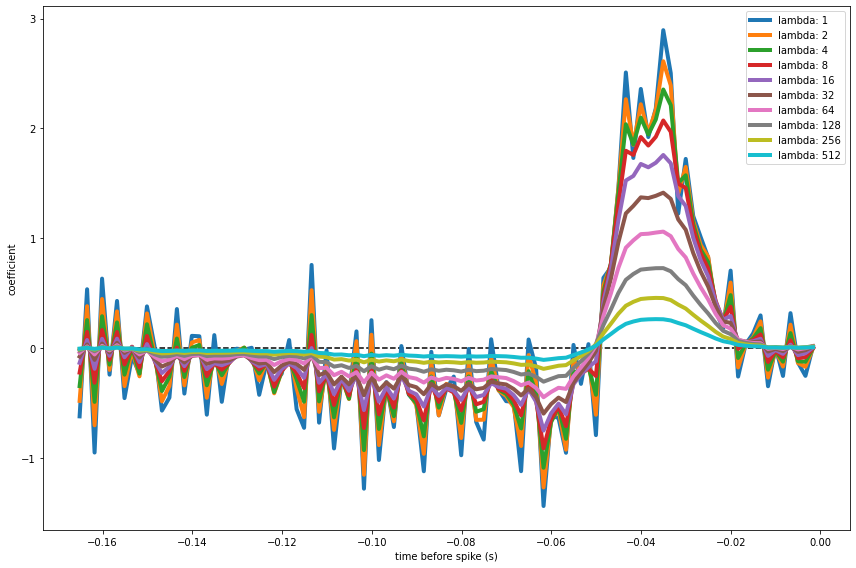

In [9]:
### === 5. Ridge regression prior ======================

# Now let's regularize by adding a penalty on the sum of squared filter
# coefficients w(i) of the form:   
#       penalty(lambda) = lambda*(sum_i w(i).^2),
# where lambda is known as the "ridge" parameter.  As noted in tutorial3,
# this is equivalent to placing an iid zero-mean Gaussian prior on the RF
# coefficients with variance equal to 1/lambda. Lambda is thus the inverse
# variance or "precision" of the prior.

# To set lambda, we'll try a grid of values and use
# cross-validation (test error) to select which is best.  

# Set up grid of lambda values (ridge parameters)
lamvals = 2**np.arange(10) # it's common to use a log-spaced set of values
nlam = len(lamvals)

# Precompute some quantities (X'X and X'*y) for training and test data
Imat = np.identity(ntfilt+1) # identity matrix of size of filter + const
Imat[0,0] = 0 # remove penalty on constant dc offset

# Allocate space for train and test errors
negLtrain = np.zeros(nlam)  # training error
negLtest = np.zeros(nlam)   # test error
w_ridge = np.zeros((ntfilt+1, nlam)) # filters for each lambda

# Define train and test log-likelihood funcs
neglogli_train_func = lambda prs : neglogli_poissGLM(prs, design_mat_train, binned_spikes_train, dt_fine)
neglogli_test_func = lambda prs : neglogli_poissGLM(prs, design_mat_test, binned_spikes_test, dt_fine)

# Now compute MAP estimate for each ridge parameter
wmap = filt_ML # initialize parameter estimate
fig = plt.figure(figsize=[12,8])
plt.plot(ttk, ttk*0, c='k', linestyle='--')
plt.ylabel('coefficient')
plt.xlabel('time before spike (s)')
for idx, lam in enumerate(lamvals):
    print('lambda: ' + str(lam))
    
    # Compute ridge-penalized MAP estimate
    Cinv = lam*Imat # set inverse prior covariance
    loss_post_func = lambda prs : neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=0)
    grad_post_func = lambda prs : neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=1)
    hess_post_func = lambda prs : neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=2)
    optimizer = minimize(fun=loss_post_func, x0=wmap, method='trust-ncg', jac=grad_post_func, hess=hess_post_func, tol=1e-6, options={'disp':True})
    wmap = optimizer.x
    
    # Compute negative logli
    negLtrain[idx] = neglogli_poissGLM(wmap, design_mat_train, binned_spikes_train, dt_fine, vals_to_return=0) # training loss
    negLtest[idx] = neglogli_poissGLM(wmap, design_mat_test, binned_spikes_test, dt_fine, vals_to_return=0) # test loss
    
    # store the filter
    w_ridge[:,idx] = wmap
    
    # plot it
    plt.plot(ttk, wmap[2:], linewidth=4, label='lambda: ' + str(lam))
#     plt.title(['ridge estimate: lambda = ', str(lamvals[idx])])

# note that the esimate "shrinks" down as we increase lambda
plt.legend()
plt.tight_layout()
plt.show()

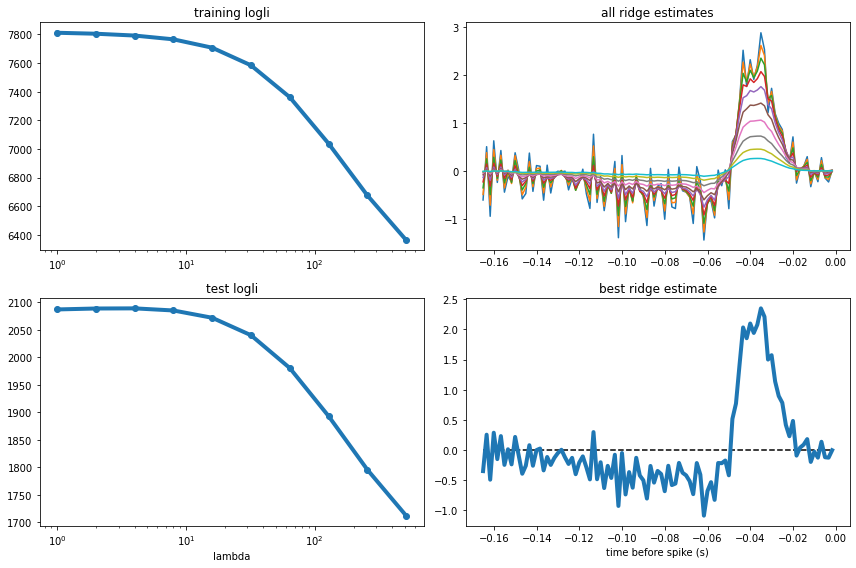

In [50]:
### ===== Plot filter estimates and errors for ridge estimates =====
fig = plt.figure(figsize=[12,8])
plt.subplot(222)
plt.plot(ttk, w_ridge[2:,:])
plt.title('all ridge estimates')
plt.subplot(221)
plt.semilogx(lamvals, -negLtrain,'o-', linewidth=4)
plt.title('training logli')
plt.subplot(223)
plt.semilogx(lamvals, -negLtest,'-o', linewidth=4)
plt.xlabel('lambda')
plt.title('test logli')

# Notice that training error gets monotonically worse as we increase lambda
# However, test error has an dip at some optimal, intermediate value.

# Determine which lambda is best by selecting one with lowest test error 
imin = np.argmin(negLtest)
filt_ridge = w_ridge[2:,imin]
plt.subplot(224)
plt.plot(ttk, ttk*0, c='k', linestyle='--')
plt.plot(ttk, filt_ridge, linewidth=4)
plt.xlabel('time before spike (s)')
plt.title('best ridge estimate')

plt.tight_layout()
plt.show()

lambda: 1
Optimization terminated successfully.
         Current function value: -7794.767604
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
         Hessian evaluations: 15
lambda: 2
Optimization terminated successfully.
         Current function value: -7788.310249
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
         Hessian evaluations: 9
lambda: 4
Optimization terminated successfully.
         Current function value: -7781.947281
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
         Hessian evaluations: 9
lambda: 8
Optimization terminated successfully.
         Current function value: -7775.110514
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Hessian evaluations: 8
lambda: 16
Optimization terminated successfully.
         Current function value: -7766.084071
         Iterations: 8
         Funct

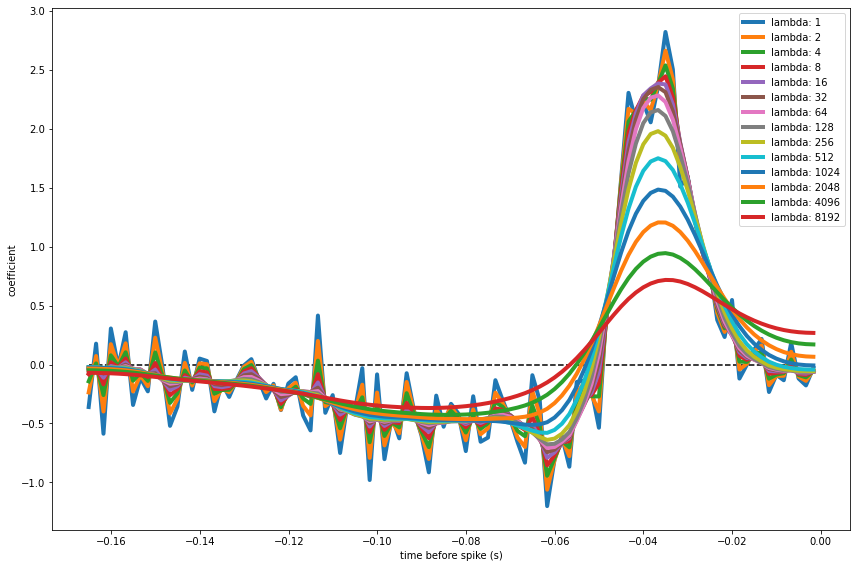

In [98]:
### === 6. L2 smoothing prior ===========================

from scipy.sparse import diags
from scipy.linalg import block_diag
# Use penalty on the squared differences between filter coefficients,
# penalizing large jumps between successive filter elements. This is
# equivalent to placing an iid zero-mean Gaussian prior on the increments
# between filter coeffs.  (See tutorial 3 for visualization of the prior
# covariance).

# This matrix computes differences between adjacent coeffs
Dx1 = diags((np.ones((ntfilt,1)) @ [[1,-1]]).T, np.arange(2), (ntfilt-1, ntfilt)).A
Dx = Dx1.T @ Dx1 # computes squared diffs

# Select smoothing penalty by cross-validation 
lamvals = 2**np.arange(14) # it's common to use a log-spaced set of values
nlam = len(lamvals)

# Embed Dx matrix in matrix with one extra row/column for constant coeff
D = block_diag(0, Dx)

# Allocate space for train and test errors
negLtrain_sm = np.zeros(nlam)  # training error
negLtest_sm = np.zeros(nlam)   # test error
w_smooth = np.zeros((ntfilt+1, nlam)) # filters for each lambda

# Define train and test log-likelihood funcs
neglogli_train_func = lambda prs : neglogli_poissGLM(prs, design_mat_train, binned_spikes_train, dt_fine)
neglogli_test_func = lambda prs : neglogli_poissGLM(prs, design_mat_test, binned_spikes_test, dt_fine)

# Now compute MAP estimate for each ridge parameter
wmap = filt_ML # initialize parameter estimate
fig = plt.figure(figsize=[12,8])
plt.plot(ttk, ttk*0, c='k', linestyle='--')
plt.ylabel('coefficient')
plt.xlabel('time before spike (s)')
for idx, lam in enumerate(lamvals):
    print('lambda: ' + str(lam))
    
    # Compute ridge-penalized MAP estimate
    Cinv = lam*D # set inverse prior covariance
    loss_post_func = lambda prs : neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=0)
    grad_post_func = lambda prs : neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=1)
    hess_post_func = lambda prs : neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=2)
    optimizer = minimize(fun=loss_post_func, x0=wmap, method='trust-ncg', jac=grad_post_func, hess=hess_post_func, tol=1e-6, options={'disp':True})
    wmap = optimizer.x
    
    # Compute negative logli
    negLtrain_sm[idx] = neglogli_poissGLM(wmap, design_mat_train, binned_spikes_train, dt_fine, vals_to_return=0) # training loss
    negLtest_sm[idx] = neglogli_poissGLM(wmap, design_mat_test, binned_spikes_test, dt_fine, vals_to_return=0) # test loss
    
    # store the filter
    w_smooth[:,idx] = wmap
    
    # plot it
    plt.plot(ttk, wmap[2:], linewidth=4, label='lambda: ' + str(lam))
#     plt.title(['ridge estimate: lambda = ', str(lamvals[idx])])

# note that the esimate "shrinks" down as we increase lambda
plt.legend()
plt.tight_layout()
plt.show()

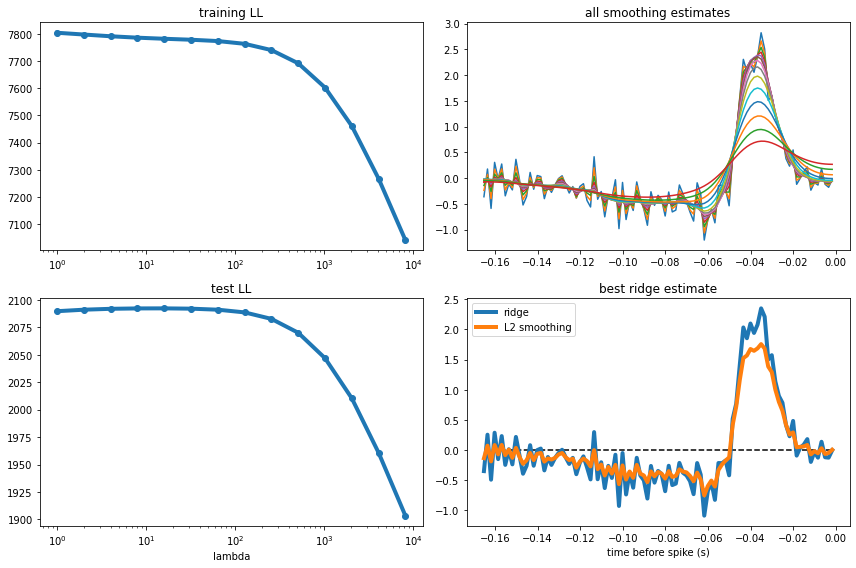

Best ridge test LL:      2092.28348
Best smoothing test LL:  2092.28348


In [97]:
### ===== Plot filter estimates and errors for smoothing estimates =====
fig = plt.figure(figsize=[12,8])
plt.subplot(222)
plt.plot(ttk, w_smooth[2:,:])
plt.title('all smoothing estimates')
plt.subplot(221)
plt.semilogx(lamvals, -negLtrain_sm,'o-', linewidth=4)
plt.title('training LL')
plt.subplot(223)
plt.semilogx(lamvals, -negLtest_sm,'-o', linewidth=4)
plt.xlabel('lambda')
plt.title('test LL')

# Notice that training error gets monotonically worse as we increase lambda
# However, test error has an dip at some optimal, intermediate value.

# Determine which lambda is best by selecting one with lowest test error 
imin = np.argmin(negLtest_sm)
filt_smooth = w_ridge[2:,imin]
plt.subplot(224)
plt.plot(ttk, ttk*0, c='k', linestyle='--')
plt.plot(ttk, filt_ridge, linewidth=4, label='ridge')
plt.plot(ttk, filt_smooth, linewidth=4, label='L2 smoothing')
plt.xlabel('time before spike (s)')
plt.title('best ridge estimate')
plt.legend()
plt.tight_layout()
plt.show()

# clearly the "L2 smoothing" filter looks better by eye!

# Last, lets see which one actually achieved lower test error
print(f'Best ridge test LL:      {-min(negLtest):.5f}')
print(f'Best smoothing test LL:  {-min(negLtest_sm):.5f}')